# Read from File and Convert to Dataframe

In [86]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.ml import Pipeline
import re
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

spark = SparkSession \
    .builder \
    .appName("dataframe-spark") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

def mapper(line):
    line = re.split("(__label__[0-9] )", line)
    line[2] = re.split(":", line[2])
    return [int(line[1][-2]), line[2][0], line[2][1][1:]]

def readandConverttoDF(path):
    fields = StructType([
                StructField("label", IntegerType(), True), 
                StructField("title", StringType(), True),
                StructField("text", StringType(), True),
            ])
    df = sc.textFile(path) \
        .map(lambda line: mapper(line)) \
        .toDF(schema=fields) \
        .select("title", "text", "label")
    return df

train_data = readandConverttoDF("./data/train.ft.txt")
test_data = readandConverttoDF("./data/test.ft.txt")

# Beware, these prints take approximately 10 minutes in total. You can stop the execution here if you want to examine other cells
train_data.show()
print("Total train data:", train_data.count())
print("Total train data with positive class:", train_data.filter(col('label') == 2).count())
print("Total train data with negative class:", train_data.filter(col('label') == 1).count())
test_data.show()
print("Total test data:", test_data.count())
print("Total test data with positive class:", test_data.filter(col('label') == 2).count())
print("Total test data with negative class:", test_data.filter(col('label') == 1).count())

+--------------------+--------------------+-----+
|               title|                text|label|
+--------------------+--------------------+-----+
|Stuning even for ...|This sound track ...|    2|
|The best soundtra...|I'm reading a lot...|    2|
|            Amazing!|This soundtrack i...|    2|
|Excellent Soundtrack|I truly like this...|    2|
|Remember, Pull Yo...|If you've played ...|    2|
|an absolute maste...|I am quite sure a...|    2|
|        Buyer beware|This is a self-pu...|    1|
|      Glorious story|I loved Whisper o...|    2|
|    A FIVE STAR BOOK|I just finished r...|    2|
|Whispers of the W...|This was a easy t...|    2|
|          The Worst!|A complete waste ...|    1|
|          Great book|This was a great ...|    2|
|          Great Read|I thought this bo...|    2|
|           Oh please|I guess you have ...|    1|
|Awful beyond belief!|I feel I have to ...|    1|
|Don't try to fool...|It's glaringly ob...|    1|
|A romantic zen ba...|When you hear fol...|    2|


KeyboardInterrupt: 

# Exploratory Data Analysis

## 1. Checking Null Values

In [60]:
# Beware, these checks take approximately 10 minutes in total.
# But must be addressed because the paper said that there were 2 null reviews, but couldn't be found here.
train_data.where(col("text").isNull()).show()

In [61]:
train_data.where(col("label").isNull()).show()

In [62]:
test_data.where(col("text").isNull()).show()

+-----+----+-----+
|title|text|label|
+-----+----+-----+
+-----+----+-----+



In [63]:
test_data.where(col("label").isNull()).show()

+-----+----+-----+
|title|text|label|
+-----+----+-----+
+-----+----+-----+



## 2. Word Count and Length Text

In [64]:
data_train = train_data.withColumn('wordCount', size(split(col('text'), ' '))).withColumn('textLength', length(col('text')))
data_test = test_data.withColumn('wordCount', size(split(col('text'), ' '))).withColumn('textLength', length(col('text')))
data_train.show()
data_test.show()

+--------------------+--------------------+-----+---------+----------+
|               title|                text|label|wordCount|textLength|
+--------------------+--------------------+-----+---------+----------+
|Stuning even for ...|This sound track ...|    2|       75|       394|
|The best soundtra...|I'm reading a lot...|    2|       91|       470|
|            Amazing!|This soundtrack i...|    2|      128|       750|
|Excellent Soundtrack|I truly like this...|    2|       56|       318|
|Remember, Pull Yo...|If you've played ...|    2|       33|       174|
|an absolute maste...|I am quite sure a...|    2|      139|       800|
|        Buyer beware|This is a self-pu...|    1|      137|       724|
|      Glorious story|I loved Whisper o...|    2|      103|       506|
|    A FIVE STAR BOOK|I just finished r...|    2|       99|       506|
|Whispers of the W...|This was a easy t...|    2|       58|       270|
|          The Worst!|A complete waste ...|    1|       33|       204|
|     

(array([ 19040.,  12960.,   7947.,  11260.,  52590., 116220., 112776.,
         99422.,  91237.,  84665.,  83479.,  75379.,  71658.,  69049.,
         65747.,  65232.,  59484.,  56366.,  53434.,  50530.,  50914.,
         45635.,  43161.,  41419.,  39183.,  39602.,  35511.,  34016.,
         31646.,  30014.,  30236.,  26678.,  25664.,  24296.,  22779.,
         22983.,  20469.,  19309.,  18553.,  17635.,  17220.,  16035.,
         15201.,  14119.,  13761.,  13674.,  12273.,  10869.,   7081.,
          1589.]),
 array([   0. ,   20.2,   40.4,   60.6,   80.8,  101. ,  121.2,  141.4,
         161.6,  181.8,  202. ,  222.2,  242.4,  262.6,  282.8,  303. ,
         323.2,  343.4,  363.6,  383.8,  404. ,  424.2,  444.4,  464.6,
         484.8,  505. ,  525.2,  545.4,  565.6,  585.8,  606. ,  626.2,
         646.4,  666.6,  686.8,  707. ,  727.2,  747.4,  767.6,  787.8,
         808. ,  828.2,  848.4,  868.6,  888.8,  909. ,  929.2,  949.4,
         969.6,  989.8, 1010. ]),
 <a list of 50 Pat

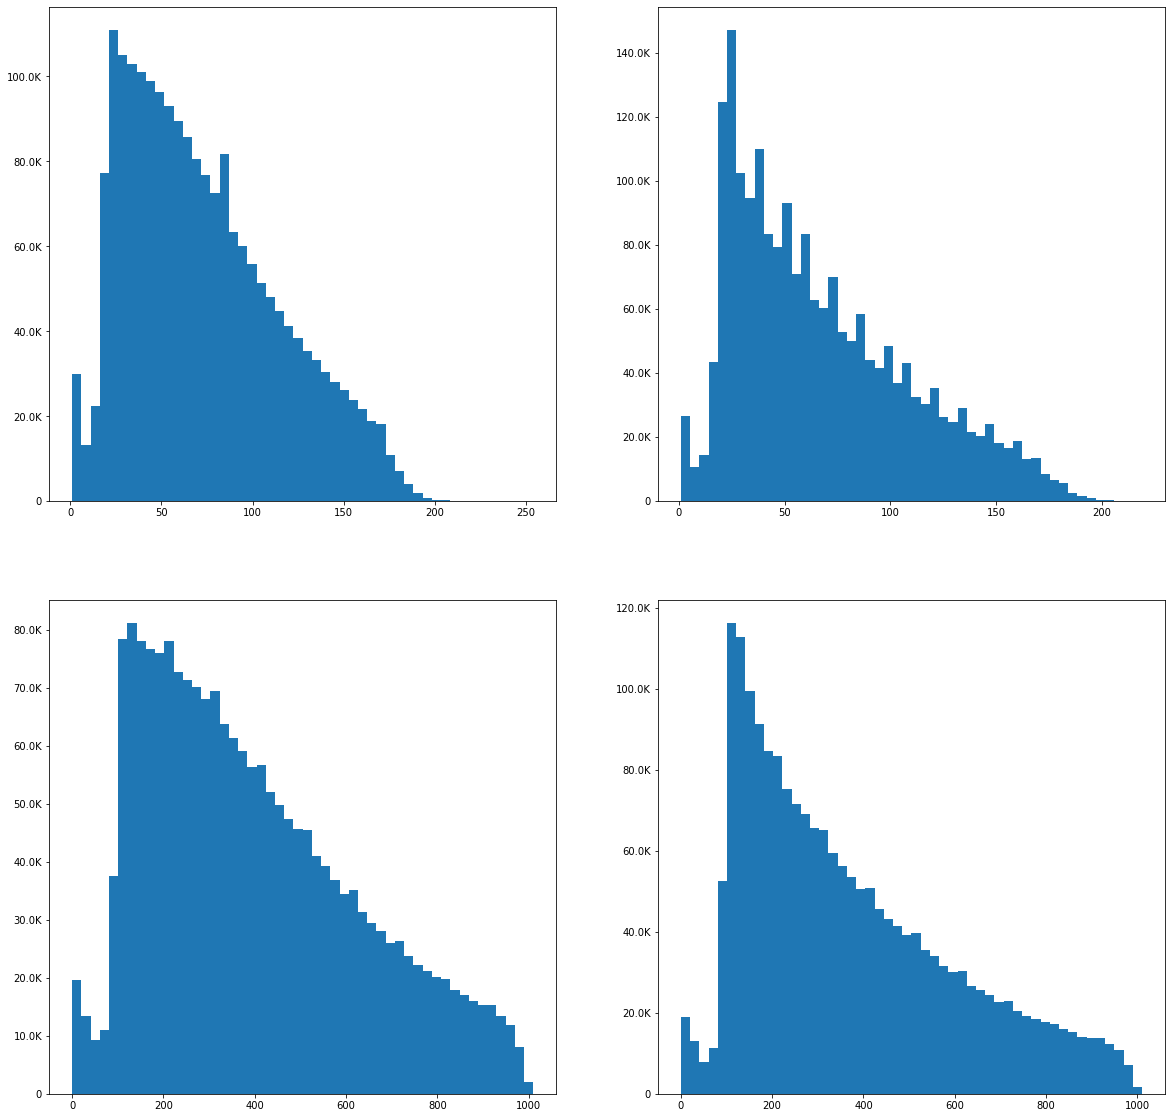

In [53]:
data = data_train.union(data_test)
data_positive = data.filter(col('label') == 2)
data_negative = data.filter(col('label') == 1)
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(20, 20)

# Beware, these histograms take approximately 15 minutes in total
hist(ax[0,0], data_negative.select("wordCount").alias("wordCountNegativeClass"), bins = 50)
hist(ax[0,1], data_positive.select("wordCount").alias("wordCountPositiveClass"), bins = 50)
hist(ax[1,0], data_negative.select("textLength").alias("textLengthNegativeClass"), bins = 50)
hist(ax[1,1], data_positive.select("textLength").alias("textLengthPositiveClass"), bins = 50)

# Data Preprocessing

## 1. Noise Removal

In [87]:
# No URL removal, must be addressed
train_data = train_data.select(regexp_replace(col("text"),"[^a-zA-Z]", "").alias("noiseRemoval"), "label")
train_data.show(truncate=False)
test_data = test_data.select(regexp_replace(col("text"),"[^a-zA-Z]", "").alias("noiseRemoval"), "label")
test_data.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|noiseRemoval                                                                                                                                                                                                                     

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|noiseRemoval                                                                                                                                               

## 2. Tokenization

In [88]:
tokenizer = Tokenizer(inputCol="noiseRemoval", outputCol="tokens")
'''
train_data = tokenizer.transform(train_data).select("tokens")
train_data.show(truncate=False)
test_data = tokenizer.transform(test_data).select("tokens")
test_data.show(truncate=False)
'''

'\ntrain_data = tokenizer.transform(train_data).select("tokens")\ntrain_data.show(truncate=False)\ntest_data = tokenizer.transform(test_data).select("tokens")\ntest_data.show(truncate=False)\n'

## 3. Stopwords Removal

In [89]:
remover = StopWordsRemover(inputCol="tokens", outputCol="tokensWithoutStopwords")
# Haven't checked of stopwords that are not contained in spark. Must be addressed.
'''
train_data = remover.transform(train_data).select("tokensWithoutStopwords")
train_data.show(truncate=False)
test_data = remover.transform(test_data).select("tokensWithoutStopwords")
test_data.show(truncate=False)
'''

'\ntrain_data = remover.transform(train_data).select("tokensWithoutStopwords")\ntrain_data.show(truncate=False)\ntest_data = remover.transform(test_data).select("tokensWithoutStopwords")\ntest_data.show(truncate=False)\n'

# Feature Extraction

In [90]:
count_vectorizer = CountVectorizer(inputCol="tokensWithoutStopwords", outputCol="rawFeatures", numFeatures=20)
idf = IDF(inputCol="rawFeatures", outputCol="features")
label_to_index = StringIndexer(inputCol = "label", outputCol = "target")

pipeline = Pipeline(stages=[tokenizer, remover, count_vectorizer, idf, label_to_index])

fitting = pipeline.fit(train_data)
train_data = fitting.transform(train_data)
test_data = fitting.transform(test_data)
train_data.show()
test_data.show()

+--------------------+-----+--------------------+----------------------+--------------------+--------------------+------+
|        noiseRemoval|label|              tokens|tokensWithoutStopwords|         rawFeatures|            features|target|
+--------------------+-----+--------------------+----------------------+--------------------+--------------------+------+
|This sound track ...|    2|[this, sound, tra...|  [sound, track, be...|(20,[0,3,4,5,6,7,...|(20,[0,3,4,5,6,7,...|   1.0|
|Im reading a lot ...|    2|[im, reading, a, ...|  [im, reading, lot...|(20,[0,1,2,3,4,5,...|(20,[0,1,2,3,4,5,...|   1.0|
|This soundtrack i...|    2|[this, soundtrack...|  [soundtrack, favo...|(20,[0,1,3,5,6,7,...|(20,[0,1,3,5,6,7,...|   1.0|
|I truly like this...|    2|[i, truly, like, ...|  [truly, like, sou...|(20,[0,1,4,5,6,7,...|(20,[0,1,4,5,6,7,...|   1.0|
|If youve played t...|    2|[if, youve, playe...|  [youve, played, g...|(20,[4,5,8,10,11,...|(20,[4,5,8,10,11,...|   1.0|
|I am quite sure a...|  